## Fetal Immune - B cells subset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt

### Load data

In [3]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.B_CLEAN.batchCorrected.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


KeyError: 'Could not find key leiden_100 in .var_names or .obs.columns.'

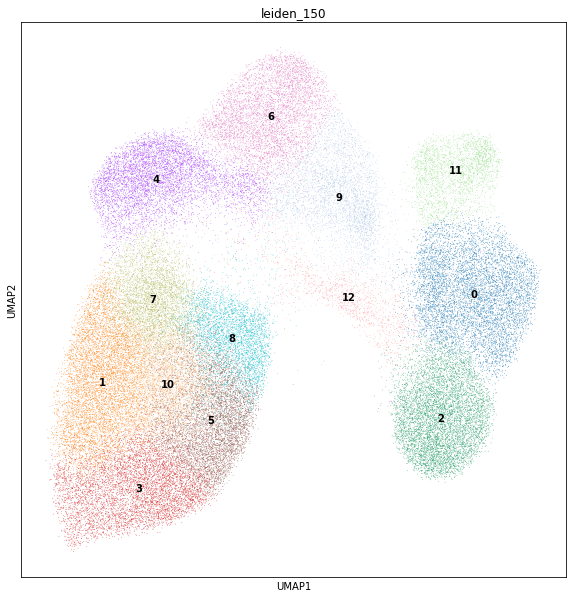

In [4]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["leiden_150", "leiden_100"], legend_loc="on data")

### Move cluster 13 and 17 to myeloid

In [8]:
adata_clean = adata[~adata.obs.leiden_150.isin(['13','17'])]
adata_2myeloid = adata[adata.obs.leiden_150.isin(['13','17'])]

#### Load raw

In [11]:
adata_raw = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.B_CLEAN.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
adata_raw[adata_clean.obs_names].write_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.B_CLEAN_CLEAN.h5ad")
adata_raw[adata_2myeloid.obs_names].write_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.B_CLEAN_2MYELOID.h5ad")

### Load clean data

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


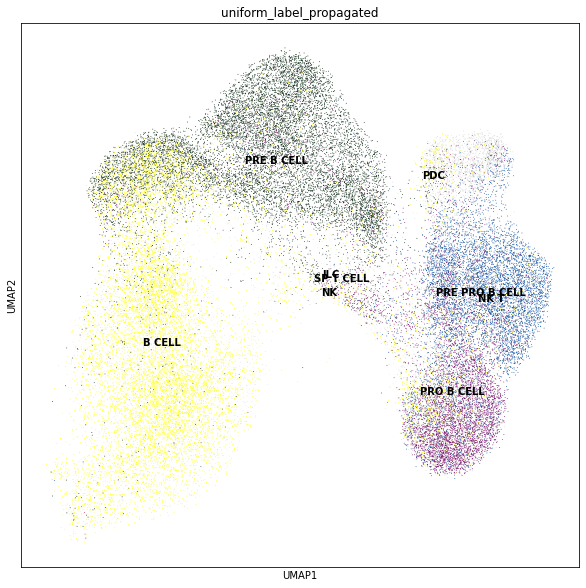

In [5]:
sc.pl.umap(adata[adata.obs.organ!="SP"], color=["uniform_label_propagated"], legend_loc="on data", 
          groups=adata[adata.obs.organ=="SP"].obs['uniform_label_propagated'][adata[adata.obs.organ=="SP"].obs['uniform_label_lvl0'] == "LYMPHOID"].unique())

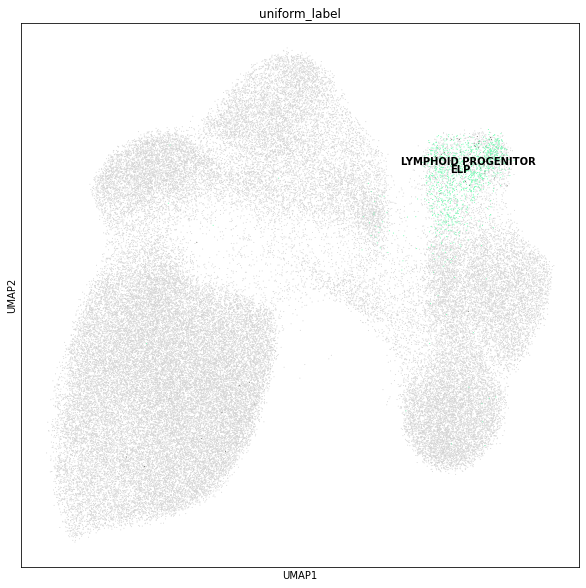

In [6]:
sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=["LYMPHOID PROGENITOR", "ELP"], size=4)

### Annotate clusters using most frequent label 

In [7]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_expanded_merged', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_expanded_merged']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_expanded_merged'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

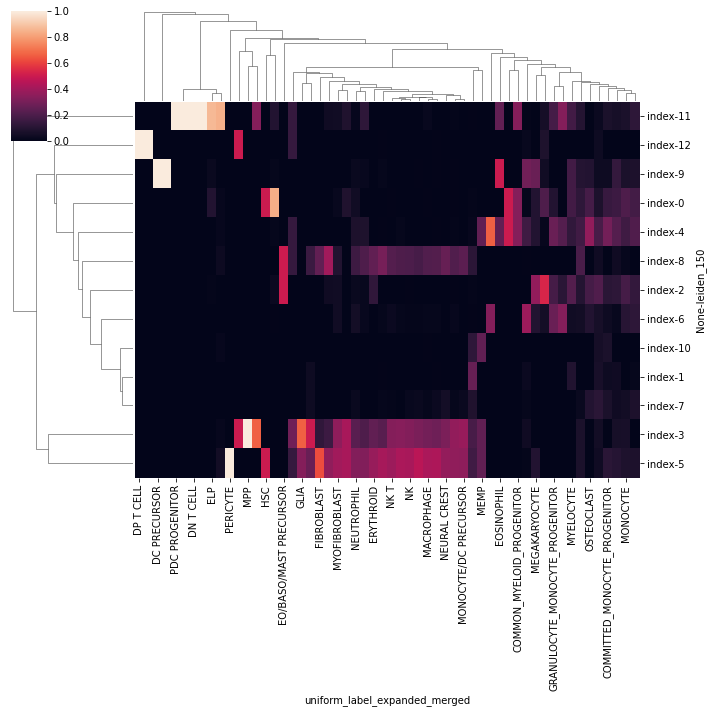

In [8]:
import seaborn as sns
sns.clustermap(cl_counts.T/cl_counts.sum(1))

... storing 'leiden_150_pred_label' as categorical


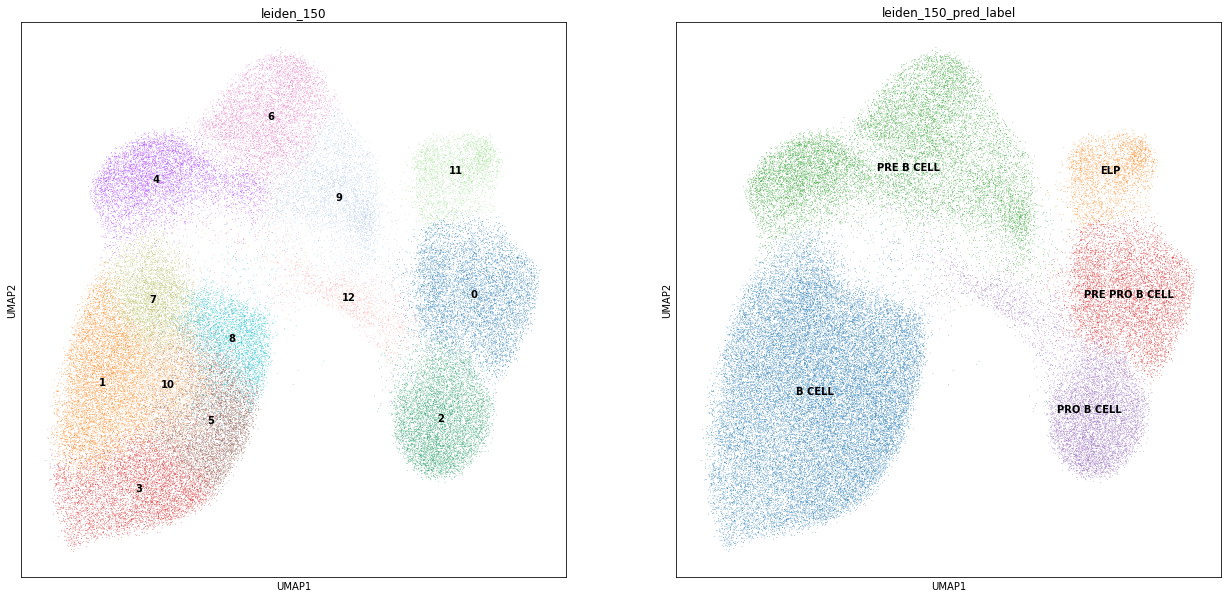

In [9]:
sc.pl.umap(adata, color=["leiden_150", "leiden_150_pred_label"], legend_loc="on data")